In [32]:
import math
import numpy as np
from torch import nn
from torch.nn import init
from torch.nn.modules import loss
import torch
from utils import gradient_descent, dist, sgd

In [33]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

## Восставновление матрицы малого ранга (5 баллов)

Есть неизвестная матрица X_taget. (В тетрадке она хранится явно, для самопроверки)
X_noised - зашумленная матрица, по которой нужно восстановить X_taget.

Для решения задачи. Нужно задать две матрицы $H$, $W$ и найти минимум $|| W * H = X_{noisy} ||$ методом градиентного спуска.

Явно пропишите градиенты матриц в градиентном спуске, не используя автоматическое дифференцирование.

Напишите градиетный спуск и подберите learning rate и количетсво итераций.


In [34]:
def get_x():
    np.random.seed(12345)
    w_ = np.random.randn(73, 6)
    h_ = np.random.randn(6, 46)
    x_target = w_.dot(h_)
    return torch.tensor(x_target, dtype=torch.float32), torch.tensor(x_target + np.random.randn(73, 46) * 0.1, dtype=torch.float32)

In [35]:
X_target, X_noisy = get_x()
W = torch.randn(73, 6, requires_grad=False, dtype=torch.float32)
H = torch.randn(6, 46, requires_grad=False, dtype=torch.float32)

In [36]:
learning_rate = 1e-4
num_iterations = 2000

In [37]:
losses = gradient_descent(X_noisy, W, H, num_iterations, learning_rate)

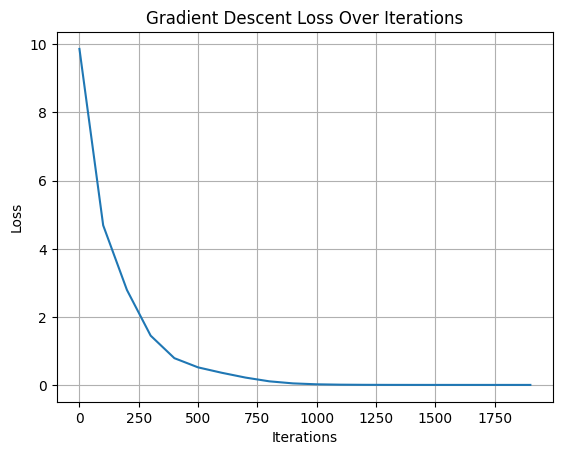

In [38]:
plt.plot(range(0, num_iterations, 100), losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Gradient Descent Loss Over Iterations')
plt.grid(True)
plt.show()

In [39]:
base_dist = dist(X_noisy, X_target).item()
recovered_dist = dist(W.matmul(H), X_target).item()

In [40]:
print(f"Distance to noisy matrix:     {base_dist}")
print(f"Distance to recovered matrix: {recovered_dist}")
print(base_dist / recovered_dist)

Distance to noisy matrix:     0.010014712810516357
Distance to recovered matrix: 0.002183907898142934
4.585684597336855


In [41]:
assert recovered_dist < base_dist

## Эластичная веревка (7 баллов)

Эластичная веревка свободно провисает между двумя опорами. Нужно смоделировать какую форму примет веревка.

Представим веревку как набор одинаковых грузов, соединенных невесомыми пружинами. Нам требуется найти такое положение грузов, в котором суммарная потенциальная энергия будет минимальна.

Потенциальная энергия груза зависит от высоты:

$$ E^m_i = mgh_i = mgy_i $$

Потенциальная энергия пружины зависит от расстояния между соседним грузами $ d_{i, i+1} $

$$ E^s_{i,i+1} = k (d_{i, i+1} - d_0) ^ 2 / 2 $$

Запишите выражение для энергии и найдите минимум методом градиентного спуска. (Не забудьте, что крайние грузы зафиксированы их положение всегда равно начальному)

Ниже заданы все необходимые константы:
* `g` - ускорение свободного падения $g$
* `x_start`, `y_start` - начальные координаты грузов
* `start_dist` - длина пружины с свобдном состоянии $d_0$
* `k` - коэффициент упругости пружины $k$
* `mass` - масса груза $m$

Формулами пропишите вычисление градиента, не используйте авт

In [13]:
joints_number = 40
g = 9.81 # м/с2

x_start = np.linspace(0, 1, num=joints_number + 1)
y_start = np.zeros(joints_number + 1)

start_dist = 1 / joints_number # м
k = 1 * joints_number # Н/м
mass = 0.01 / (joints_number + 1) # кг

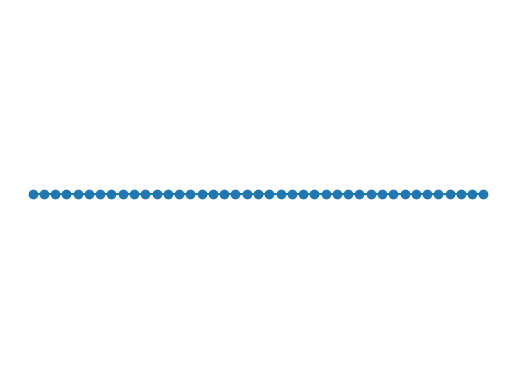

In [14]:
plt.axis("off")
plt.plot(x_start, y_start, marker='o')
plt.show()

In [17]:
def E_mass(x, y):
    return mass * g * torch.sum(y)

def E_springs(x, y):
    total_energy = 0.0
    for i in range(joints_number):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        length = torch.sqrt(dx**2 + dy**2)
        total_energy += 0.5 * k * (length - start_dist)**2
    return total_energy

def E(x, y):
    return E_mass(x, y) + E_springs(x, y)

def callback(iteration, loss_value):
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}: Energy = {loss_value}")

In [28]:
x = torch.tensor(x_start, requires_grad=True, dtype=torch.float32)
y = torch.tensor(y_start, requires_grad=True, dtype=torch.float32)

In [29]:
learning_rate = 1e-2
num_iterations = 10000

In [30]:
params = [x, y]
params_optimized = sgd(params=params, loss_fn=E, num_iterations=num_iterations, learning_rate=learning_rate, stop_loss_value=-0.007, fix_ends=True, callback=callback)

Iteration 0: Energy = 3.7511660444522477e-13
Iteration 1000: Energy = -0.002097569638863206
Iteration 2000: Energy = -0.003849529894068837
Iteration 3000: Energy = -0.00525496993213892
Iteration 4000: Energy = -0.00631954800337553
Iteration 4908: Reached stop loss value = -0.007. Stopping optimization.


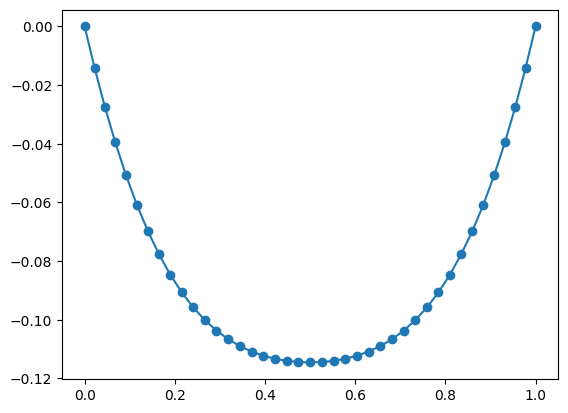

In [31]:
plt.plot(params_optimized[0].detach().numpy(), params_optimized[1].detach().numpy(), label="Fix ends", marker='o')
plt.show()